<a href="https://colab.research.google.com/github/OtolaHan/Otola_Han_KAAN/blob/main/proba2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas scikit-learn openpyxl

Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Точность модели: 0.82
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       493
           1       0.00      0.00      0.00         5
           2       0.71      0.68      0.70        79
           3       0.79      0.89      0.83       471

    accuracy                           0.82      1048
   macro avg       0.59      0.59      0.59      1048
weighted avg       0.82      0.82      0.81      1048

Был ли осуществлен привод
0    0.478769
3    0.441078
2    0.076574
1    0.003578
Name: proportion, dtype: float64
ROC-AUC: 0.97


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


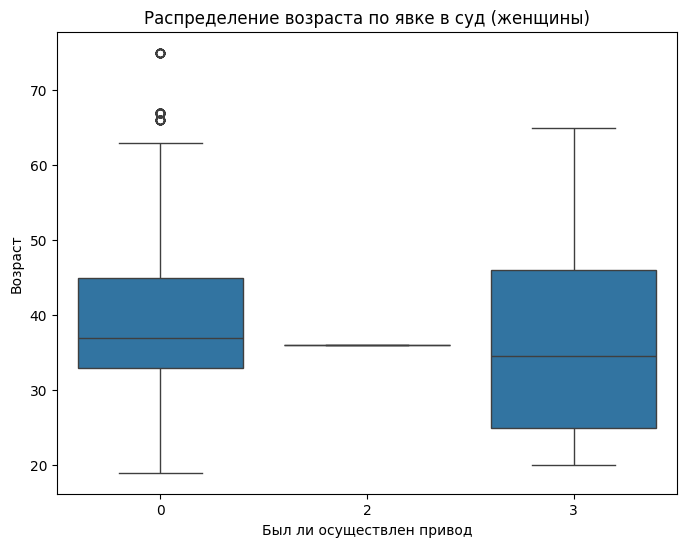

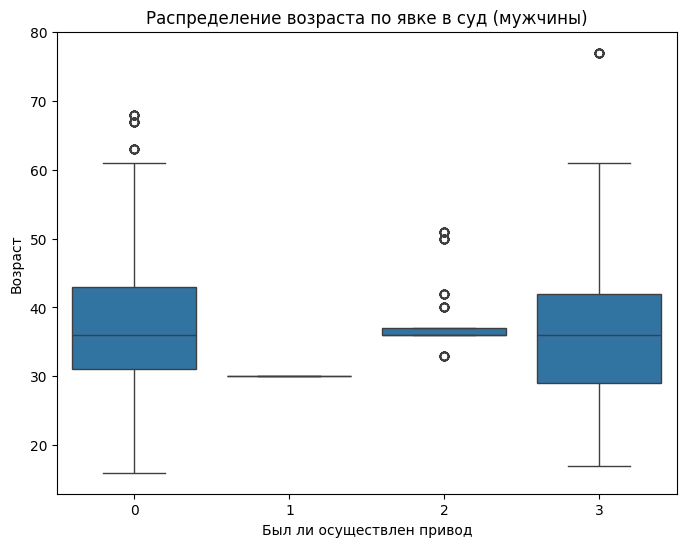

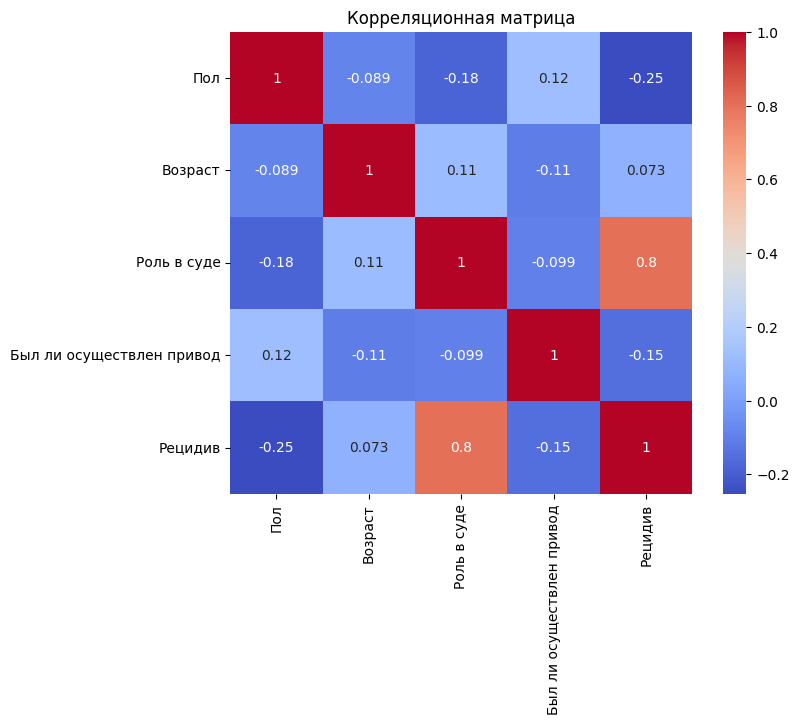

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


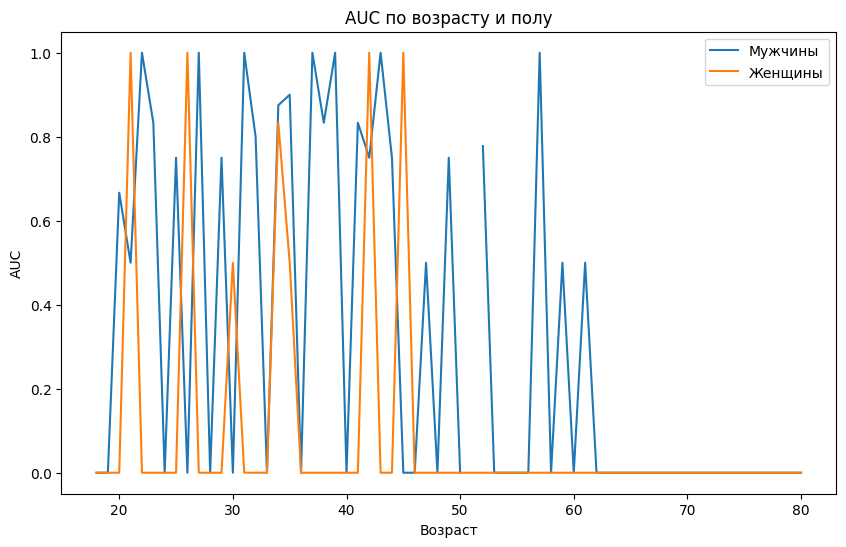

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Загрузка данных
data = pd.read_excel('/content/Data_Set4.xlsx')
data.replace('н.д.', pd.NA, inplace=True)
data['Возраст'].fillna(data['Возраст'].median(), inplace=True)

# Очистка данных от пробелов
data['Пол'] = data['Пол'].str.strip()

le_dict = {}  # Добавьте эту строку перед циклом

# Инициализация LabelEncoder для каждого категориального столбца и его обучение
for column in ['Пол', 'Роль в суде', 'Был ли осуществлен привод', 'Рецидив']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    le_dict[column] = le  # Сохранение обученного LabelEncoder для возможного будущего использования

X = data.drop('Был ли осуществлен привод', axis=1)  # Все столбцы кроме целевой переменной
y = data['Был ли осуществлен привод']  # Целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Настройка гиперпараметров с помощью GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}")

predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Точность модели: {accuracy:.2f}")

print("Отчет о классификации:")
print(classification_report(y_test, predictions))
print(y_train.value_counts(normalize=True))

# Вычисление ROC-AUC для мультиклассовой задачи
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
roc_auc = roc_auc_score(y_test_binarized, best_model.predict_proba(X_test), multi_class='ovr')
print(f"ROC-AUC: {roc_auc:.2f}")

# Создание DataFrame для хранения предсказаний
predictions_df = pd.DataFrame(columns=['Пол', 'Возраст', 'Роль в суде', 'Рецидив', 'Вероятность посещения'])

# Генерация предсказаний для различных комбинаций пола, возраста, роли в суде и рецидива
for gender in ['Мужской', 'Женский']:
    for age in range(18, 81):
        for role in ['Свидетель', 'Обвиняемый', 'Потерпевший']:
            for recidivism in ['Нет', 'Да']:
                new_data = pd.DataFrame({
                    'Пол': [le_dict['Пол'].transform([gender])[0]],
                    'Возраст': [age],
                    'Роль в суде': [le_dict['Роль в суде'].transform([role])[0]],
                    'Рецидив': [le_dict['Рецидив'].transform([recidivism])[0]]
                })

                new_prediction = best_model.predict_proba(new_data)[:, 1]  # Вероятность посещения (класс 1)
                predictions_df = pd.concat([predictions_df, pd.DataFrame({
                    'Пол': [gender],
                    'Возраст': [age],
                    'Роль в суде': [role],
                    'Рецидив': [recidivism],
                    'Вероятность посещения': [new_prediction[0]]
                })], ignore_index=True)

# Сохранение предсказаний в файл Astra.csv
predictions_df.to_csv('Astra.csv', index=False)

# Разделение данных по полу
data_female = data[data['Пол'] == le_dict['Пол'].transform(['Женский'])[0]]
data_male = data[data['Пол'] == le_dict['Пол'].transform(['Мужской'])[0]]

# График распределения возраста по явке в суд для женщин
plt.figure(figsize=(8, 6))
sns.boxplot(x='Был ли осуществлен привод', y='Возраст', data=data_female)
plt.title('Распределение возраста по явке в суд (женщины)')
plt.show()

# График распределения возраста по явке в суд для мужчин
plt.figure(figsize=(8, 6))
sns.boxplot(x='Был ли осуществлен привод', y='Возраст', data=data_male)
plt.title('Распределение возраста по явке в суд (мужчины)')
plt.show()

# Корреляционная матрица
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Корреляционная матрица')
plt.show()

# Оценка модели для каждого возраста и пола
age_range = range(18, 81)
auc_scores_male = []
auc_scores_female = []

for age in age_range:
    X_age_male = data_male[data_male['Возраст'] == age].drop('Был ли осуществлен привод', axis=1)
    y_age_male = data_male[data_male['Возраст'] == age]['Был ли осуществлен привод']

    X_age_female = data_female[data_female['Возраст'] == age].drop('Был ли осуществлен привод', axis=1)
    y_age_female = data_female[data_female['Возраст'] == age]['Был ли осуществлен привод']

    if len(y_age_male.unique()) == 2:
        model_age_male = RandomForestClassifier(random_state=42)
        model_age_male.fit(X_age_male, y_age_male)
        y_pred_proba_male = model_age_male.predict_proba(X_age_male)[:, 1]
        # Указываем pos_label=3
        fpr_male, tpr_male, _ = roc_curve(y_age_male, y_pred_proba_male, pos_label=3)
        auc_score_male = auc(fpr_male, tpr_male)
        auc_scores_male.append(auc_score_male)
    else:
        auc_scores_male.append(0)

    if len(y_age_female.unique()) == 2:
        model_age_female = RandomForestClassifier(random_state=42)
        model_age_female.fit(X_age_female, y_age_female)
        y_pred_proba_female = model_age_female.predict_proba(X_age_female)[:, 1]
        # Указываем pos_label=3
        fpr_female, tpr_female, _ = roc_curve(y_age_female, y_pred_proba_female, pos_label=3)
        auc_score_female = auc(fpr_female, tpr_female)
        auc_scores_female.append(auc_score_female)
    else:
        auc_scores_female.append(0)

# График AUC для мужчин и женщин по возрасту
plt.figure(figsize=(10, 6))
plt.plot(age_range, auc_scores_male, label='Мужчины')
plt.plot(age_range, auc_scores_female, label='Женщины')
plt.xlabel('Возраст')
plt.ylabel('AUC')
plt.title('AUC по возрасту и полу')
plt.legend()
plt.show()

Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Точность модели: 0.82
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       493
           1       0.00      0.00      0.00         5
           2       0.71      0.68      0.70        79
           3       0.79      0.89      0.83       471

    accuracy                           0.82      1048
   macro avg       0.59      0.59      0.59      1048
weighted avg       0.82      0.82      0.81      1048

Был ли осуществлен привод
0    0.478769
3    0.441078
2    0.076574
1    0.003578
Name: proportion, dtype: float64
ROC-AUC: 0.97
Предсказание для нового экземпляра данных (мужской): 0
Предсказание для нового экземпляра данных (женский): 3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


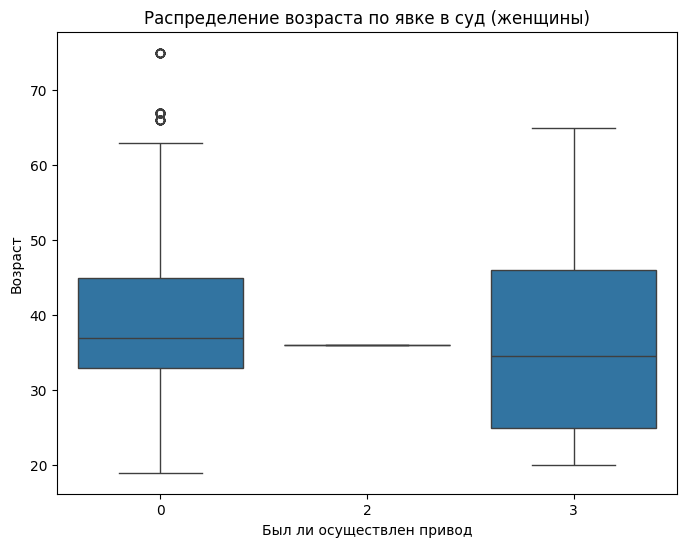

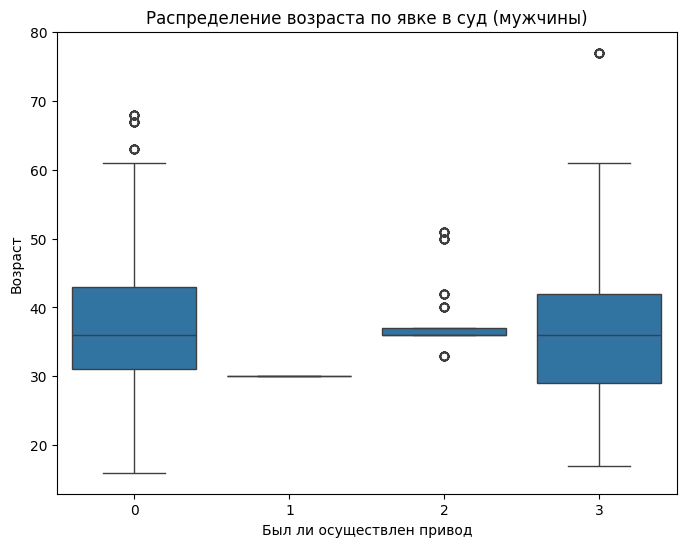

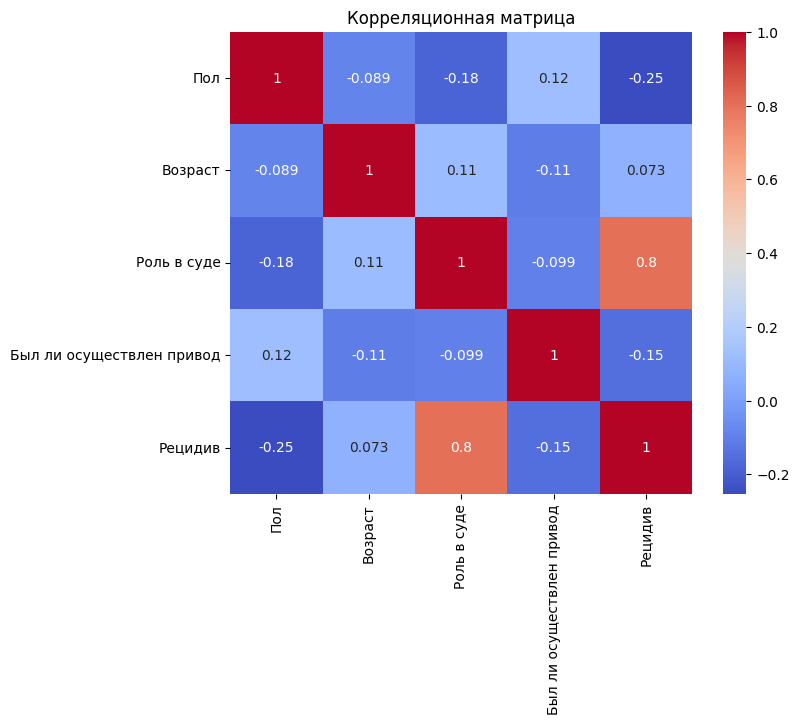

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


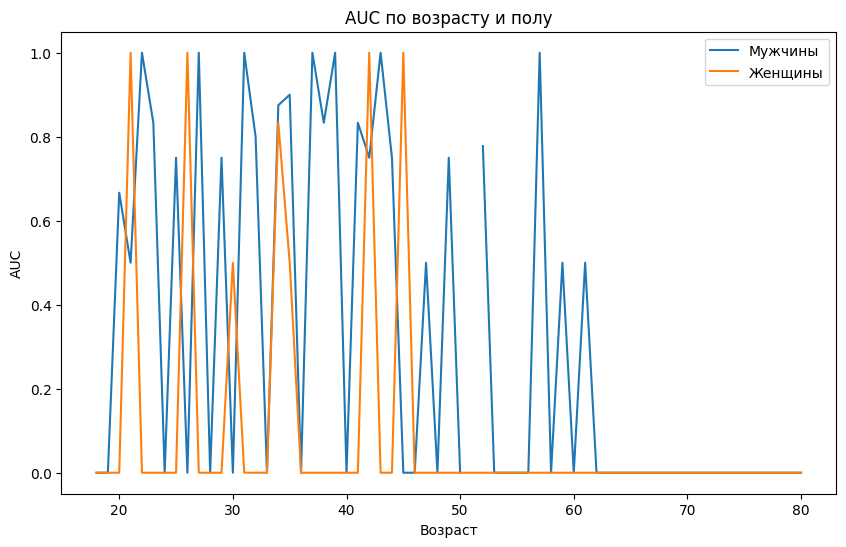

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Загрузка данных
data = pd.read_excel('/content/Data_Set4.xlsx')
data.replace('н.д.', pd.NA, inplace=True)
data['Возраст'].fillna(data['Возраст'].median(), inplace=True)

# Очистка данных от пробелов
data['Пол'] = data['Пол'].str.strip()

le_dict = {}  # Добавьте эту строку перед циклом

# Инициализация LabelEncoder для каждого категориального столбца и его обучение
for column in ['Пол', 'Роль в суде', 'Был ли осуществлен привод', 'Рецидив']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    le_dict[column] = le  # Сохранение обученного LabelEncoder для возможного будущего использования

X = data.drop('Был ли осуществлен привод', axis=1)  # Все столбцы кроме целевой переменной
y = data['Был ли осуществлен привод']  # Целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Настройка гиперпараметров с помощью GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}")

predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Точность модели: {accuracy:.2f}")

print("Отчет о классификации:")
print(classification_report(y_test, predictions))
print(y_train.value_counts(normalize=True))

# Вычисление ROC-AUC для мультиклассовой задачи
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
roc_auc = roc_auc_score(y_test_binarized, best_model.predict_proba(X_test), multi_class='ovr')
print(f"ROC-AUC: {roc_auc:.2f}")

# Пример данных для предсказания (замените значения на актуальные)
new_data = pd.DataFrame({
    'Пол': [le_dict['Пол'].transform(['Мужской'])[0]],
    'Возраст': [31],
    'Роль в суде': [le_dict['Роль в суде'].transform(['Обвиняемый'])[0]],
    'Рецидив': [le_dict['Рецидив'].transform(['Да'])[0]]
})

# Создадим новый экземпляр данных с закодированным значением 'Женский'
new_data_female = pd.DataFrame({
    'Пол': [le_dict['Пол'].transform(['Женский'])[0]],
    'Возраст': [31],
    'Роль в суде': [le_dict['Роль в суде'].transform(['Свидетель'])[0]],
    'Рецидив': [le_dict['Рецидив'].transform(['Да'])[0]]
})

# Получение предсказаний для новых экземпляров данных
new_prediction = best_model.predict(new_data)
new_prediction_female = best_model.predict(new_data_female)

print(f"Предсказание для нового экземпляра данных (мужской): {new_prediction[0]}")
print(f"Предсказание для нового экземпляра данных (женский): {new_prediction_female[0]}")


# Разделение данных по полу
data_female = data[data['Пол'] == le_dict['Пол'].transform(['Женский'])[0]]
data_male = data[data['Пол'] == le_dict['Пол'].transform(['Мужской'])[0]]

# График распределения возраста по явке в суд для женщин
plt.figure(figsize=(8, 6))
sns.boxplot(x='Был ли осуществлен привод', y='Возраст', data=data_female)
plt.title('Распределение возраста по явке в суд (женщины)')
plt.show()

# График распределения возраста по явке в суд для мужчин
plt.figure(figsize=(8, 6))
sns.boxplot(x='Был ли осуществлен привод', y='Возраст', data=data_male)
plt.title('Распределение возраста по явке в суд (мужчины)')
plt.show()

# Корреляционная матрица
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Корреляционная матрица')
plt.show()

# Оценка модели для каждого возраста и пола
age_range = range(18, 81)
auc_scores_male = []
auc_scores_female = []

for age in age_range:
    X_age_male = data_male[data_male['Возраст'] == age].drop('Был ли осуществлен привод', axis=1)
    y_age_male = data_male[data_male['Возраст'] == age]['Был ли осуществлен привод']

    X_age_female = data_female[data_female['Возраст'] == age].drop('Был ли осуществлен привод', axis=1)
    y_age_female = data_female[data_female['Возраст'] == age]['Был ли осуществлен привод']

    if len(y_age_male.unique()) == 2:
        model_age_male = RandomForestClassifier(random_state=42)
        model_age_male.fit(X_age_male, y_age_male)
        y_pred_proba_male = model_age_male.predict_proba(X_age_male)[:, 1]
        # Указываем pos_label=3
        fpr_male, tpr_male, _ = roc_curve(y_age_male, y_pred_proba_male, pos_label=3)
        auc_score_male = auc(fpr_male, tpr_male)
        auc_scores_male.append(auc_score_male)
    else:
        auc_scores_male.append(0)

    if len(y_age_female.unique()) == 2:
        model_age_female = RandomForestClassifier(random_state=42)
        model_age_female.fit(X_age_female, y_age_female)
        y_pred_proba_female = model_age_female.predict_proba(X_age_female)[:, 1]
        # Указываем pos_label=3
        fpr_female, tpr_female, _ = roc_curve(y_age_female, y_pred_proba_female, pos_label=3)
        auc_score_female = auc(fpr_female, tpr_female)
        auc_scores_female.append(auc_score_female)
    else:
        auc_scores_female.append(0)

# График AUC для мужчин и женщин по возрасту
plt.figure(figsize=(10, 6))
plt.plot(age_range, auc_scores_male, label='Мужчины')
plt.plot(age_range, auc_scores_female, label='Женщины')
plt.xlabel('Возраст')
plt.ylabel('AUC')
plt.title('AUC по возрасту и полу')
plt.legend()
plt.show()